In [1]:
import pandas as pd

df = pd.read_excel('satisfaction xl.xlsx')
df.head()

,month_id,survey_date,subs_no,brand_medallia,survey_type,macro_journey,micro_journey,brand,brand_category,category,...,trx_mov1,trx_mov2,trx_mov3,trx_mov4,trx_mov5,rpt_mov1,rpt_mov2,rpt_mov3,rpt_mov4,rpt_mov5
0,202412,2024-12-18,52940263,XL PREPAID,XL_Channel_Apps Performance_Apps Interface,Apps Performance,Apps Interface,XL,XL PREPAID,Touchpoint,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202412,2024-12-05,47772513,XL PREPAID,XL_Channel_Manage My Usage_Quota Information,Manage My Usage,Quota Information,XL,XL PREPAID,Touchpoint,...,0.0,1.0,-3.0,-2.0,-2.0,-28517.717718,34545.795796,5346.396396,11374.474474,39892.192192
2,202412,2024-12-18,2064752097,XL PREPAID,XL_Product_Buy Package_Ease to Find Package,Buy Package,Easy to find packet,XL,XL PREPAID,Product,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-43819.819820,-61351.351351,NaN
3,202412,2024-12-11,55253504,XL PREPAID,XL_Channel_Manage My Usage_Quota Information,Manage My Usage,Quota Information,XL,XL PREPAID,Touchpoint,...,0.0,1.0,-1.0,0.0,0.0,-7522.522523,6452.702703,-2477.477477,-3547.297297,3975.225225
4,202412,2024-12-07,1388265608,XL PREPAID,XL_Channel_Apps Performance_Apps Interface,Apps Performance,Apps Interface,XL,XL PREPAID,Touchpoint,...,NaN,0.0,0.0,NaN,0.0,NaN,-1857.657658,-5123.423423,NaN,-6981.081081


### Preprocessing

In [2]:
columns_to_drop = ['month_id', 'survey_date', 'subs_no', 'reason_for_score', 'survey_type', 'dom_cdmainid', 'tnps_segment', 'main_score']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

In [3]:
financial_columns = [
    'arpu_m0', 'arpu_m1', 'arpu_m2', 'arpu_m3', 'arpu_90d_m0', 'arpu_90d_m1', 'arpu_90d_m2', 'arpu_90d_m3',
    'mrev_90d_m0', 'mrev_90d_m1', 'mrev_90d_m2', 'mrev_90d_m3', 'mrev_data_90d_m0', 'mrev_data_90d_m1', 
    'mrev_data_90d_m2', 'mrev_data_90d_m3', 'mrev_voice_90d_m0', 'mrev_voice_90d_m1', 'mrev_voice_90d_m2', 
    'mrev_voice_90d_m3', 'rembal_m0', 'rembal_m1', 'rembal_m2', 'rembal_m3', 'dom_price', 'rev_m0', 'rev_m1', 
    'rev_m2', 'rev_m3', 'trx_m0', 'trx_m1', 'trx_m2', 'trx_m3', 'rev_per_trx_m0', 'rev_per_trx_m1', 
    'rev_per_trx_m2', 'rev_per_trx_m3', 'arpu_mov1', 'arpu_mov2', 'arpu_mov3', 'arpu_mov4', 'arpu_mov5', 
    'rpt_mov1', 'rpt_mov2', 'rpt_mov3', 'rpt_mov4', 'rpt_mov5'
]

existing_financial_columns = [col for col in financial_columns if col in df.columns]

df[existing_financial_columns] = df[existing_financial_columns].apply(pd.to_numeric, errors='coerce')

df[existing_financial_columns] = df[existing_financial_columns].fillna(0)

numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(exclude=['number']).columns
df[categorical_columns] = df[categorical_columns].astype(str)

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
if 'unhappy_flag2' in df.columns:
    df = df.drop(columns=['unhappy_flag2'])

X = df.drop(columns=['unhappy_flag1'])
y = df['unhappy_flag1']

In [6]:
y = y.astype(int)

### Feature Importance

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
80,kabupaten,0.017455
42,dsls_m0,0.016121
10,arpu_90d_m0,0.015678
84,rtt_xl_10,0.015627
83,latency_xl_10,0.015485
...,...,...
86,cx_centric_flag,0.001213
67,akrab_user_flag,0.000803
0,brand_medallia,0.000046
4,brand_category,0.000000


In [10]:
feature_importance.to_csv("feature_importance.csv", index=False)
print("Feature Importance Table (saved as CSV):")

Feature Importance Table (saved as CSV):


C:\Users\mades\AppData\Local\Temp\ipykernel_30708\950251449.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='coolwarm')


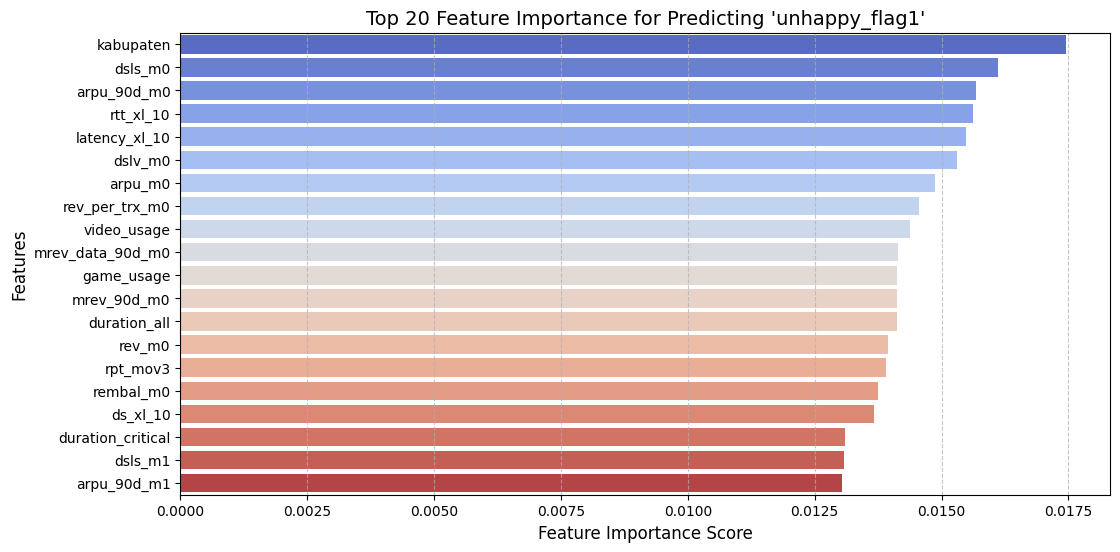

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Limit to top 20 most important features
top_features = feature_importance.head(20)

# Visualizing only the top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x=top_features['Importance'], y=top_features['Feature'], palette='coolwarm')
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top 20 Feature Importance for Predicting 'unhappy_flag1'", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Model ML Top 20 Feattures

In [12]:
top_20_features = [
    'kabupaten', 'dsls_m0', 'arpu_90d_m0', 'rtt_xl_10', 'latency_xl_10',
    'dslv_m0', 'arpu_m0', 'rev_per_trx_m0', 'video_usage', 'mrev_data_90d_m0',
    'game_usage', 'mrev_90d_m0', 'duration_all', 'rev_m0', 'rpt_mov3',
    'rembal_m0', 'ds_xl_10', 'duration_critical', 'dsls_m1', 'arpu_90d_m1'
]

target = 'unhappy_flag1'

X = df[top_20_features]
y = df[target]

In [13]:
y = y.astype(int)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8159324705491953

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39319
           1       0.55      0.01      0.03      8897

    accuracy                           0.82     48216
   macro avg       0.68      0.51      0.46     48216
weighted avg       0.77      0.82      0.74     48216



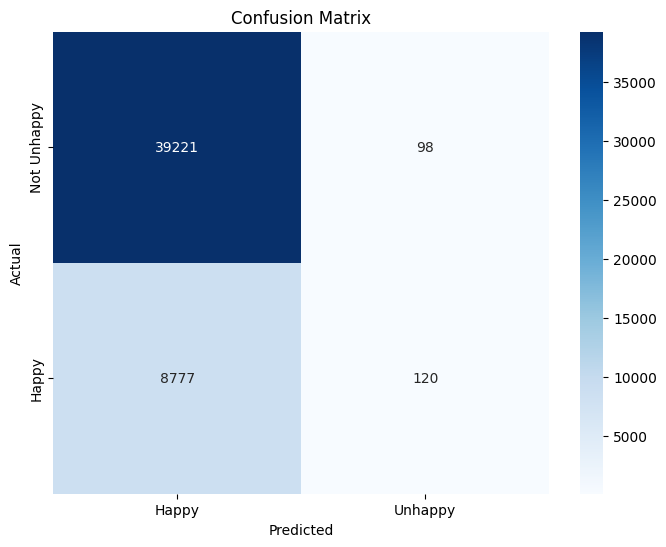

In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Happy', 'Unhappy'], yticklabels=['Not Unhappy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### ML Model Top 50 Features

In [19]:
top_50_features = [
    'kabupaten', 'dsls_m0', 'arpu_90d_m0', 'rtt_xl_10', 'latency_xl_10',
    'dslv_m0', 'arpu_m0', 'rev_per_trx_m0', 'video_usage', 'mrev_data_90d_m0',
    'game_usage', 'mrev_90d_m0', 'duration_all', 'rev_m0', 'rpt_mov3',
    'rembal_m0', 'ds_xl_10', 'duration_critical', 'dsls_m1', 'arpu_90d_m1',
    'arpu_mov3', 'dom_pack_name', 'dslv_m1', 'dom_price', 'dsls_m2',
    'rpt_mov5', 'rev_per_trx_m1', 'arpu_m1', 'arpu_90d_m2', 'rembal_m1',
    'dsls_m3', 'rpt_mov4', 'rpt_mov2', 'arpu_90d_m3', 'arpu_mov5',
    'dslv_m2', 'rev_m1', 'mrev_data_90d_m1', 'ss_xl_10', 'mrev_90d_m1',
    'rembal_m2', 'arpu_mov2', 'dslv_m3', 'arpu_mov4', 'arpu_m2',
    'rpt_mov1', 'dwe_m0', 'rembal_m3', 'mrev_data_90d_m2', 'mrev_90d_m2'
]

target = 'unhappy_flag1'

X = df[top_50_features]
y = df[target]

y = y.astype(int)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8162643106022897

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39319
           1       0.60      0.01      0.03      8897

    accuracy                           0.82     48216
   macro avg       0.71      0.51      0.46     48216
weighted avg       0.78      0.82      0.74     48216



### ML Model All Features

In [23]:
all_features = [
    'kabupaten', 'dsls_m0', 'arpu_90d_m0', 'rtt_xl_10', 'latency_xl_10', 'dslv_m0', 'arpu_m0',
    'rev_per_trx_m0', 'video_usage', 'mrev_data_90d_m0', 'game_usage', 'mrev_90d_m0', 'duration_all',
    'rev_m0', 'rpt_mov3', 'rembal_m0', 'ds_xl_10', 'duration_critical', 'dsls_m1', 'arpu_90d_m1',
    'arpu_mov3', 'dom_pack_name', 'dslv_m1', 'dom_price', 'dsls_m2', 'rpt_mov5', 'rev_per_trx_m1',
    'arpu_m1', 'arpu_90d_m2', 'rembal_m1', 'dsls_m3', 'rpt_mov4', 'rpt_mov2', 'arpu_90d_m3',
    'arpu_mov5', 'dslv_m2', 'rev_m1', 'mrev_data_90d_m1', 'ss_xl_10', 'mrev_90d_m1', 'rembal_m2',
    'arpu_mov2', 'dslv_m3', 'arpu_mov4', 'arpu_m2', 'rpt_mov1', 'dwe_m0', 'rembal_m3', 'mrev_data_90d_m2',
    'mrev_90d_m2', 'mrev_90d_m3', 'rev_per_trx_m2', 'arpu_mov1', 'arpu_m3', 'mrev_data_90d_m3',
    'rev_per_trx_m3', 'rev_m2', 'dom_allowance', 'duration_catash', 'rev_m3', 'total_incident_all',
    'total_incident_critical', 'micro_journey', 'trx_mov3', 'mrev_voice_90d_m0', 'dwe_m1', 'trx_m0',
    'trx_mov5', 'dwv_m0', 'total_incident_catash', 'trx_mov4', 'trx_mov2', 'region', 'dwe_m2', 'dwe_m3',
    'mrev_voice_90d_m1', 'trx_mov1', 'dwv_m1', 'trx_m1', 'macro_journey', 'mrev_voice_90d_m2',
    'mrev_voice_90d_m3', 'dwv_m3', 'dwv_m2', 'dom_pack_group', 'trx_m2', 'trx_m3', 'dsle_m0',
    'usage_segment', 'dws_m0', 'dom_discount', 'arpu_segment', 'dws_m1', 'tenure_cat', 'dom_validity',
    'dsle_m1', 'dws_m3', 'dws_m2', 'dsle_m2', 'dom_channel', 'dsle_m3', 'value_segment_90d_m3',
    'complaint_sum', 'inquiries_sum', 'dom_camp_type', 'value_segment_90d_m1', 'value_segment_90d_m2',
    'category', 'interaction_sum', 'value_segment_90d_m0', 'voice_user_m0', 'voice_user_m3',
    'high_apps_engagement_flag', 'voice_user_m1', 'voice_user_m2', 'cx_centric_flag', 'akrab_user_flag',
    'brand_medallia'
]

In [24]:
target = 'unhappy_flag1'

X = df[all_features]
y = df[target]

y = y.astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8164302306288369

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39319
           1       0.63      0.01      0.02      8897

    accuracy                           0.82     48216
   macro avg       0.72      0.51      0.46     48216
weighted avg       0.78      0.82      0.74     48216



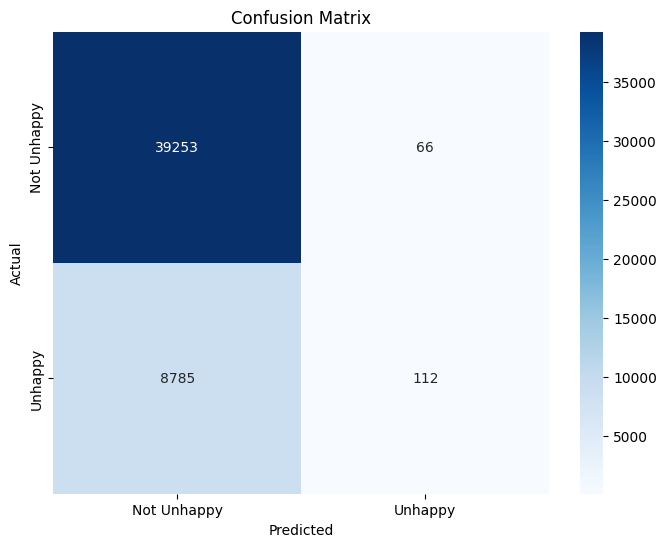

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Unhappy', 'Unhappy'], yticklabels=['Not Unhappy', 'Unhappy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_sm, y_train_sm)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8138792102206737

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     39319
           1       0.41      0.02      0.04      8897

    accuracy                           0.81     48216
   macro avg       0.61      0.51      0.47     48216
weighted avg       0.74      0.81      0.74     48216



In [30]:
# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model with adjusted threshold
print("Model Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted))

Model Accuracy: 0.6520657043305127

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77     39319
           1       0.22      0.35      0.27      8897

    accuracy                           0.65     48216
   macro avg       0.53      0.54      0.52     48216
weighted avg       0.72      0.65      0.68     48216



### Logistic Regression All Variables

In [50]:
all_features = [
    'kabupaten', 'dsls_m0', 'arpu_90d_m0', 'rtt_xl_10', 'latency_xl_10', 'dslv_m0', 'arpu_m0',
    'rev_per_trx_m0', 'video_usage', 'mrev_data_90d_m0', 'game_usage', 'mrev_90d_m0', 'duration_all',
    'rev_m0', 'rpt_mov3', 'rembal_m0', 'ds_xl_10', 'duration_critical', 'dsls_m1', 'arpu_90d_m1',
    'arpu_mov3', 'dom_pack_name', 'dslv_m1', 'dom_price', 'dsls_m2', 'rpt_mov5', 'rev_per_trx_m1',
    'arpu_m1', 'arpu_90d_m2', 'rembal_m1', 'dsls_m3', 'rpt_mov4', 'rpt_mov2', 'arpu_90d_m3',
    'arpu_mov5', 'dslv_m2', 'rev_m1', 'mrev_data_90d_m1', 'ss_xl_10', 'mrev_90d_m1', 'rembal_m2',
    'arpu_mov2', 'dslv_m3', 'arpu_mov4', 'arpu_m2', 'rpt_mov1', 'dwe_m0', 'rembal_m3', 'mrev_data_90d_m2',
    'mrev_90d_m2', 'mrev_90d_m3', 'rev_per_trx_m2', 'arpu_mov1', 'arpu_m3', 'mrev_data_90d_m3',
    'rev_per_trx_m3', 'rev_m2', 'dom_allowance', 'duration_catash', 'rev_m3', 'total_incident_all',
    'total_incident_critical', 'micro_journey', 'trx_mov3', 'mrev_voice_90d_m0', 'dwe_m1', 'trx_m0',
    'trx_mov5', 'dwv_m0', 'total_incident_catash', 'trx_mov4', 'trx_mov2', 'region', 'dwe_m2', 'dwe_m3',
    'mrev_voice_90d_m1', 'trx_mov1', 'dwv_m1', 'trx_m1', 'macro_journey', 'mrev_voice_90d_m2',
    'mrev_voice_90d_m3', 'dwv_m3', 'dwv_m2', 'dom_pack_group', 'trx_m2', 'trx_m3', 'dsle_m0',
    'usage_segment', 'dws_m0', 'dom_discount', 'arpu_segment', 'dws_m1', 'tenure_cat', 'dom_validity',
    'dsle_m1', 'dws_m3', 'dws_m2', 'dsle_m2', 'dom_channel', 'dsle_m3', 'value_segment_90d_m3',
    'complaint_sum', 'inquiries_sum', 'dom_camp_type', 'value_segment_90d_m1', 'value_segment_90d_m2',
    'category', 'interaction_sum', 'value_segment_90d_m0', 'voice_user_m0', 'voice_user_m3',
    'high_apps_engagement_flag', 'voice_user_m1', 'voice_user_m2', 'cx_centric_flag', 'akrab_user_flag',
    'brand_medallia'
]

In [51]:
X = df[all_features]
y = df[target]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

C:\Users\mades\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [54]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=== Logistic Regression (All Features) ===")
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

=== Logistic Regression (All Features) ===
Model Accuracy: 0.8153

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39319
           1       0.00      0.00      0.00      8897

    accuracy                           0.82     48216
   macro avg       0.41      0.50      0.45     48216
weighted avg       0.66      0.82      0.73     48216



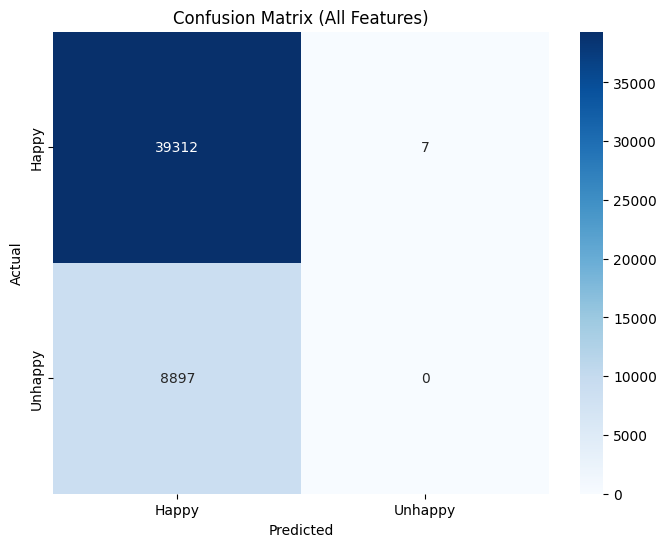

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Happy', 'Unhappy'], yticklabels=['Happy', 'Unhappy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (All Features)')
plt.show()

### Logistic Regression Numerical Features

In [61]:
numeric_features = [
    'dsls_m0', 'arpu_90d_m0', 'rtt_xl_10', 'latency_xl_10', 'dslv_m0', 'arpu_m0',
    'rev_per_trx_m0', 'video_usage', 'mrev_data_90d_m0', 'game_usage', 'mrev_90d_m0',
    'duration_all', 'rev_m0', 'rpt_mov3', 'rembal_m0', 'ds_xl_10', 'duration_critical',
    'dsls_m1', 'arpu_90d_m1', 'arpu_mov3', 'dslv_m1', 'dom_price', 'dsls_m2', 'rpt_mov5',
    'rev_per_trx_m1', 'arpu_m1', 'arpu_90d_m2', 'rembal_m1', 'dsls_m3', 'rpt_mov4',
    'rpt_mov2', 'arpu_90d_m3', 'arpu_mov5', 'dslv_m2', 'rev_m1', 'mrev_data_90d_m1',
    'ss_xl_10', 'mrev_90d_m1', 'rembal_m2', 'arpu_mov2', 'dslv_m3', 'arpu_mov4',
    'arpu_m2', 'rpt_mov1', 'dwe_m0', 'rembal_m3', 'mrev_data_90d_m2', 'mrev_90d_m2',
    'mrev_90d_m3', 'rev_per_trx_m2', 'arpu_mov1', 'arpu_m3', 'mrev_data_90d_m3',
    'rev_per_trx_m3', 'rev_m2', 'dom_allowance', 'duration_catash', 'rev_m3',
    'total_incident_all', 'total_incident_critical', 'trx_mov3', 'mrev_voice_90d_m0',
    'dwe_m1', 'trx_mov5', 'dwv_m0', 'total_incident_catash', 'trx_mov4',
    'trx_mov2', 'dwe_m2', 'dwe_m3', 'mrev_voice_90d_m1', 'trx_mov1', 'dwv_m1',
    'mrev_voice_90d_m2', 'mrev_voice_90d_m3', 'dwv_m3', 'dwv_m2',
    'dsle_m0', 'dws_m0', 'dws_m1', 'dom_validity', 'dsle_m1',
    'dws_m3', 'dws_m2', 'dsle_m2', 'dsle_m3', 'value_segment_90d_m3', 'complaint_sum',
    'inquiries_sum', 'value_segment_90d_m1', 'value_segment_90d_m2', 'interaction_sum',
    'value_segment_90d_m0', 'voice_user_m0', 'voice_user_m3', 'voice_user_m1', 'voice_user_m2'
]

In [62]:
X = df[numeric_features]
y = df[target]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

C:\Users\mades\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [64]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("=== Logistic Regression ===")
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

=== Logistic Regression ===
Model Accuracy: 0.8154

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     39319
           1       0.00      0.00      0.00      8897

    accuracy                           0.82     48216
   macro avg       0.41      0.50      0.45     48216
weighted avg       0.66      0.82      0.73     48216



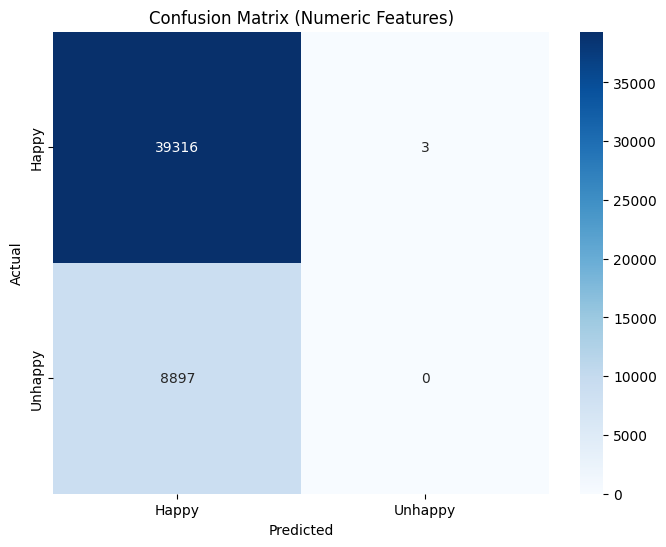

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Happy', 'Unhappy'], yticklabels=['Happy', 'Unhappy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Numeric Features)')
plt.show()